In [14]:
import numpy as np
import scipy.io as spio
from matplotlib import pyplot as plt
from matplotlib import cm
import glob
import os
import tensorflow as tf
from util import constants
from util.config_util import get_model_params, get_task_params, get_train_params
from tf2_models.trainer import Trainer
from absl import app
from absl import flags
import numpy as np
from util.models import MODELS
from util.tasks import TASKS
import tensorflow_probability as tfp
from tfds_data.aff_nist import AffNist
from calibration_util import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
sns.set_style("whitegrid")

from tqdm import tqdm

def visualization(x, y,count,index):
    x = np.reshape(x, (40, 40))
    
    plt.subplot(1,count,index)
    plt.imshow(x, cmap=cm.Greys_r)
    plt.title(y)
    plt.axis('off')   

def visualization_overlap(x0,x1, y0,y1,count,index):
    r = np.reshape(x0, (40, 40))
    g = np.reshape(x1, (40, 40))
    b = np.zeros_like(r)
    rgb = np.stack([r,g,b],-1)
    
    plt.subplot(1,count,index)
    plt.imshow(rgb)
    plt.title('R:('+ str(y0)+','+str(y1)+')')
    plt.axis('off')   


In [15]:
chkpt_dir='../tf_ckpts'
task_name = 'affnist'
task = TASKS[task_name](get_task_params(), data_dir='../data')

model config: vcnn_lenet5
{'hidden_dim': [120, 84], 'depth': 2, 'proj_depth': 2, 'filters': [6, 16], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'pool_size': [(2, 2), (2, 2), (2, 2)], 'hidden_dropout_rate': 0.5, 'input_dropout_rate': 0.2}
student_checkpoint: ../tf_ckpts/aff_nist/cl_vcnn_h-120.84_d-2_hdrop-0.5_indrop-0.2_vcnn_lenet5_0.001_trial1
Restored student from ../tf_ckpts/aff_nist/cl_vcnn_h-120.84_d-2_hdrop-0.5_indrop-0.2_vcnn_lenet5_0.001_trial1/ckpt-20
100/100 [==============================] - 0s 4ms/step - loss: 0.4306 - classification_loss: 0.4306 - sparse_categorical_accuracy: 0.9205
9984
9984


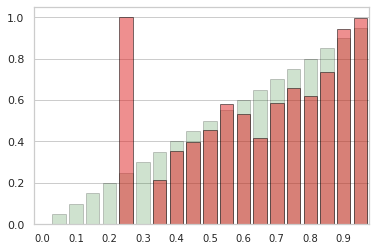

0.0817682


In [21]:
exp_name = '0.001_trial1'
model_name = 'cl_vcnn'
model_config = 'vcnn_lenet5'
model_params = get_model_params(task, model_name, model_config)
model_params.output_attentions = True
model_params.output_embeddings = True
model = MODELS[model_name](hparams=model_params)

ckpt_dir = os.path.join(chkpt_dir, 'aff_nist',
                          '_'.join([
                                    model.model_name,
                                    str(model_config),
                                    exp_name]))
print("student_checkpoint:", ckpt_dir)

ckpt = tf.train.Checkpoint(net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=None)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored student from {}".format(manager.latest_checkpoint))
else:
  print("Initialized  from scratch!")

model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
model.evaluate(task.test_dataset, steps=100)

model_accuracy, predicted_class_probs, correct_class_probs, model_logits, model_trues= test_for_calibration(model, task, n_bins=20)

print(len(model_accuracy))
print(len(predicted_class_probs))
plot_calibration(model_accuracy, predicted_class_probs, correct_class_probs, n_bins=20)
plt.show()
model_ece = tfp.stats.expected_calibration_error(
    1000000,
    logits=model_logits,
    labels_true=model_trues,
)
print(model_ece.numpy())


model config: ff_mnist
{'hidden_dim': 128, 'depth': 3, 'hidden_dropout_rate': 0.5, 'input_dropout_rate': 0.2}
student_checkpoint: ../tf_ckpts/aff_nist/cl_vff_h-128_d-3_hdrop-0.5_indrop-0.2_ff_mnist_0.001_trial1
Restored student from ../tf_ckpts/aff_nist/cl_vff_h-128_d-3_hdrop-0.5_indrop-0.2_ff_mnist_0.001_trial1/ckpt-20
100/100 [==============================] - 0s 4ms/step - loss: 0.9994 - classification_loss: 0.9994 - sparse_categorical_accuracy: 0.7628
9984
9984


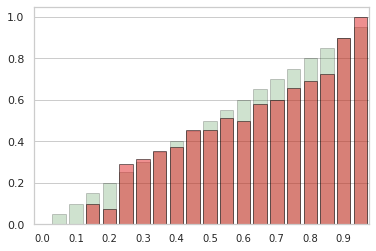

0.23837791


In [20]:
exp_name = '0.001_trial1'
model_name = 'cl_vff'
model_config = 'ff_mnist'
model_params = get_model_params(task, model_name, model_config)
model_params.output_attentions = True
model_params.output_embeddings = True
model = MODELS[model_name](hparams=model_params)

ckpt_dir = os.path.join(chkpt_dir, 'aff_nist',
                          '_'.join([
                                    model.model_name,
                                    str(model_config),
                                    exp_name]))
print("student_checkpoint:", ckpt_dir)

ckpt = tf.train.Checkpoint(net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=None)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored student from {}".format(manager.latest_checkpoint))
else:
  print("Initialized  from scratch!")

model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
model.evaluate(task.test_dataset, steps=100)

model_accuracy, predicted_class_probs, correct_class_probs, model_logits, model_trues= test_for_calibration(model, task, n_bins=20)

print(len(model_accuracy))
print(len(predicted_class_probs))
plot_calibration(model_accuracy, predicted_class_probs, correct_class_probs, n_bins=20)
plt.show()
model_ece = tfp.stats.expected_calibration_error(
    1000000,
    logits=model_logits,
    labels_true=model_trues,
)
print(model_ece.numpy())
